In [ ]:
pip install torch torchvision torchaudio torch-geometric hmmlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylin

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
import torch
from torch_geometric.data import Data

# Example bounding box coordinates (x1, y1, x2, y2) for three nodes
bbox_coordinates = torch.tensor([
    [50, 50, 100, 100],  # Bounding box for node 1
    [150, 50, 200, 100],  # Bounding box for node 2
    [250, 50, 300, 100]   # Bounding box for node 3
], dtype=torch.float)

# Example distances from CMOS and UMS for the three nodes
CMOS_distances = torch.tensor([5.0, 6.0, 7.0], dtype=torch.float)  # CMOS distances
UMS_distances = torch.tensor([5.5, 5.8, 7.1], dtype=torch.float)  # UMS distances

# Stack features together
node_features = torch.cat([bbox_coordinates, CMOS_distances.unsqueeze(1), UMS_distances.unsqueeze(1)], dim=1)

# Define edge index (connectivity of the graph)
# For simplicity, we will fully connect the graph
edge_index = torch.tensor([
    [0, 1], [1, 0],  # Edge between node 0 and node 1
    [1, 2], [2, 1],  # Edge between node 1 and node 2
    [0, 2], [2, 0]   # Edge between node 0 and node 2
], dtype=torch.long).t().contiguous()

# Create the graph data object
data = Data(x=node_features, edge_index=edge_index)

print("Node Features:\n", data.x)
print("Edge Index:\n", data.edge_index)


Node Features:
 tensor([[ 50.0000,  50.0000, 100.0000, 100.0000,   5.0000,   5.5000],
        [150.0000,  50.0000, 200.0000, 100.0000,   6.0000,   5.8000],
        [250.0000,  50.0000, 300.0000, 100.0000,   7.0000,   7.1000]])
Edge Index:
 tensor([[0, 1, 1, 2, 0, 2],
        [1, 0, 2, 1, 2, 0]])


In [ ]:
from hmmlearn import hmm

class DistanceHMM:
    def __init__(self, n_components):
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)

    def fit(self, X):
        self.model.fit(X)

    def predict(self, X):
        logprob, seq = self.model.decode(X, algorithm="viterbi")
        return seq


In [ ]:
# Initialize GCN and HMM
input_dim = node_features.shape[1]
hidden_dim = 16
output_dim = 1  # Assuming we want to output a single distance value
gcn = GCN(input_dim, hidden_dim, output_dim)
distance_hmm = DistanceHMM(n_components=3)  # Example with 3 states

# Example training loop
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
criterion = nn.MSELoss()

#Ground truth distances
ground_truth_distances = torch.tensor([5.2, 6.1, 7.0], dtype=torch.float).unsqueeze(1)

# Training the GCN
for epoch in range(100):  # Number of epochs
    gcn.train()
    optimizer.zero_grad()
    output = gcn(data.x, data.edge_index)
    loss = criterion(output, ground_truth_distances)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Inference with GCN
gcn.eval()
with torch.no_grad():
    predicted_distances = gcn(data.x, data.edge_index).numpy()

# Fit HMM on predicted distances and decode the most probable sequence
distance_hmm.fit(predicted_distances)
final_sequence = distance_hmm.predict(predicted_distances)
print(f'Final sequence of distances: {final_sequence}')


Epoch 0, Loss: 14.96725845336914
Epoch 1, Loss: 19.733957290649414
Epoch 2, Loss: 11.858698844909668
Epoch 3, Loss: 0.5473278164863586
Epoch 4, Loss: 7.554946422576904
Epoch 5, Loss: 10.604249000549316
Epoch 6, Loss: 4.120386600494385
Epoch 7, Loss: 0.5590713620185852
Epoch 8, Loss: 3.97297739982605
Epoch 9, Loss: 6.614694595336914
Epoch 10, Loss: 4.123390197753906
Epoch 11, Loss: 0.8752009272575378
Epoch 12, Loss: 1.2525731325149536
Epoch 13, Loss: 3.632631301879883
Epoch 14, Loss: 3.8947956562042236
Epoch 15, Loss: 1.845668911933899
Epoch 16, Loss: 0.5431427955627441
Epoch 17, Loss: 1.4431222677230835
Epoch 18, Loss: 2.6870243549346924
Epoch 19, Loss: 2.294037342071533
Epoch 20, Loss: 0.9673922061920166
Epoch 21, Loss: 0.5902902483940125
Epoch 22, Loss: 1.4015859365463257
Epoch 23, Loss: 1.9220166206359863
Epoch 24, Loss: 1.3569427728652954
Epoch 25, Loss: 0.6154990792274475
Epoch 26, Loss: 0.7120426297187805
Epoch 27, Loss: 1.2835497856140137
Epoch 28, Loss: 1.3367477655410767
Epoch

/usr/local/lib/python3.10/dist-packages/hmmlearn/hmm.py:314: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans.fit(X)


Epoch 94, Loss: 0.541072428226471
Epoch 95, Loss: 0.5402283072471619
Epoch 96, Loss: 0.5401472449302673
Epoch 97, Loss: 0.540766179561615
Epoch 98, Loss: 0.540435254573822
Epoch 99, Loss: 0.5400011539459229
Final sequence of distances: [1 1 1]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from hmmlearn import hmm
import numpy as np
import plotly.graph_objects as go

# Define GCN Model
class GCN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(input_dim, hidden_dim)
    # Additional hidden layer (conv4) with hidden_dim units
    self.conv2 = GCNConv(hidden_dim, hidden_dim)  # Existing layer
    self.conv3 = GCNConv(hidden_dim, hidden_dim)  # Existing layer
    self.conv4 = GCNConv(hidden_dim, output_dim)  # Added layer
    self.bn1 = nn.BatchNorm1d(hidden_dim)  # BatchNorm after conv1
    self.bn2 = nn.BatchNorm1d(hidden_dim)  # BatchNorm after conv2
    self.bn3 = nn.BatchNorm1d(hidden_dim)  # BatchNorm after conv3
    self.bn4 = nn.BatchNorm1d(hidden_dim)  # Added BatchNorm for conv4
    self.dropout = nn.Dropout(0.2)  # Dropout layer with 20% dropout rate

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = self.bn1(x)  # BatchNorm
    x = F.relu(x)
    x = self.dropout(x)  # Dropout

    x = self.conv2(x, edge_index)
    x = self.bn2(x)  # BatchNorm
    x = F.relu(x)
    x = self.dropout(x)  # Dropout

    x = self.conv3(x, edge_index)
    x = self.bn3(x)  # BatchNorm
    x = F.relu(x)
    x = self.dropout(x)  # Dropout

    # Added forward pass for conv4
    x = self.conv4(x, edge_index)
    # x = self.bn4(x)  # Added BatchNorm
    # #x = F.relu(x)
    return x


  # def __init__(self, input_dim, hidden_dim, output_dim):
  #   super(GCN, self).__init__()
  #   self.conv1 = GCNConv(input_dim, hidden_dim)
  #   self.conv2 = GCNConv(hidden_dim, hidden_dim)  # Added another GCNConv layer
  #   self.conv3 = GCNConv(hidden_dim, output_dim)  # Added another GCNConv layer
  #   self.bn = nn.BatchNorm1d(hidden_dim)  # BatchNorm layer after conv1
  #   self.dropout = nn.Dropout(0.2)  # Dropout layer with 20% dropout rate

  # def forward(self, x, edge_index):
  #   x = self.conv1(x, edge_index)
  #   x = self.bn(x)  # Added BatchNorm
  #   x = F.relu(x)
  #   x = self.dropout(x)  # Added Dropout
  #   # Removed duplicate application of conv1
  #   x = self.conv2(x, edge_index)
  #   x = self.bn(x)  # Added BatchNorm
  #   x = F.relu(x)
  #   x = self.dropout(x)  # Added Dropout
  #   x = self.conv3(x, edge_index)
  #   return x



# Generate synthetic dataset
num_nodes = 100

# Bounding box coordinates (x1, y1, x2, y2)
bbox_coordinates = torch.rand((num_nodes, 4)) * 100

# CMOS and UMS distances with some noise
true_distances = torch.linspace(5, 10, num_nodes)
CMOS_distances = true_distances + torch.randn(num_nodes) * 0.5
UMS_distances = true_distances + torch.randn(num_nodes) * 0.5

# Ground truth distances
ground_truth_distances = true_distances.unsqueeze(1)

# Stack features together
node_features = torch.cat([bbox_coordinates, CMOS_distances.unsqueeze(1)], dim=1)

# Define edge index (connect each node to its next node only)
edges = [[i, (i + 1) % num_nodes] for i in range(num_nodes)]  # Wrap around for last node
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create the graph data object
data = Data(x=node_features, edge_index=edge_index)

# Initialize GCN
input_dim = node_features.shape[1]
hidden_dim = 16
output_dim = 1  # We want to output a single distance value
gcn = GCN(input_dim, hidden_dim, output_dim)

# Training the GCN
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Lists to store loss and predicted distances
losses = []
predicted_distances_list = []

# Training loop
for epoch in range(1000):  # Number of epochs
    gcn.train()
    optimizer.zero_grad()
    output = gcn(data.x, data.edge_index)
    loss = criterion(output, UMS_distances.unsqueeze(1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    predicted_distances_list.append(output.detach().numpy())
    print(f'Epoch {epoch}, Loss: {loss.item()}')

# Verify GCN predictions
gcn.eval()
with torch.no_grad():
    predicted_distances = gcn(data.x, data.edge_index)

# Plot the loss function over epochs using Plotly
fig_loss = go.Figure()
fig_loss.add_trace(go.Scatter(x=list(range(1000)), y=losses, mode='lines', name='Training Loss'))
fig_loss.update_layout(title='Loss over Training Epochs',
                       xaxis_title='Epoch',
                       yaxis_title='Loss')
fig_loss.show()

# Plot ground truth vs predicted distance values using Plotly
fig_distances = go.Figure()
fig_distances.add_trace(go.Scatter(x=list(range(num_nodes)), y=ground_truth_distances.squeeze().numpy(), mode='lines+markers', name='Ground Truth'))
fig_distances.add_trace(go.Scatter(x=list(range(num_nodes)), y=predicted_distances.squeeze().numpy(), mode='lines+markers', name='Predicted'))
fig_distances.update_layout(title='Ground Truth vs Predicted Distances',
                            xaxis_title='Node',
                            yaxis_title='Distance')
fig_distances.show()

# Fit HMM on predicted distances and decode the most probable sequence
distance_hmm = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
distance_hmm.fit(predicted_distances)
logprob, final_sequence = distance_hmm.decode(predicted_distances, algorithm="viterbi")

print(f'Final sequence of distances: {final_sequence}')

Epoch 0, Loss: 70.00732421875
Epoch 1, Loss: 70.50508117675781
Epoch 2, Loss: 69.51571655273438
Epoch 3, Loss: 70.2451400756836
Epoch 4, Loss: 68.85702514648438
Epoch 5, Loss: 69.32572937011719
Epoch 6, Loss: 69.00430297851562
Epoch 7, Loss: 68.13744354248047
Epoch 8, Loss: 68.96814727783203
Epoch 9, Loss: 66.0213851928711
Epoch 10, Loss: 68.31573486328125
Epoch 11, Loss: 67.2436752319336
Epoch 12, Loss: 67.6147689819336
Epoch 13, Loss: 68.30438995361328
Epoch 14, Loss: 66.09135437011719
Epoch 15, Loss: 67.68809509277344
Epoch 16, Loss: 65.9234848022461
Epoch 17, Loss: 64.27949523925781
Epoch 18, Loss: 68.16217803955078
Epoch 19, Loss: 66.9529800415039
Epoch 20, Loss: 65.83409118652344
Epoch 21, Loss: 65.71170806884766
Epoch 22, Loss: 65.81826782226562
Epoch 23, Loss: 64.49417877197266
Epoch 24, Loss: 65.7293472290039
Epoch 25, Loss: 63.54377746582031
Epoch 26, Loss: 62.348236083984375
Epoch 27, Loss: 64.38299560546875
Epoch 28, Loss: 63.961402893066406
Epoch 29, Loss: 64.1426620483398

Final sequence of distances: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
# Define path to save the model
model_path = "model.pt"

# Save the model (entire model state including weights and architecture)
torch.save(gcn.state_dict(), model_path)

print(f"Model saved to: {model_path}")

Model saved to: model.pt


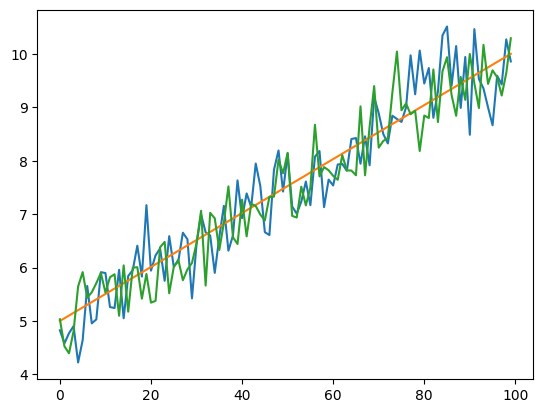

In [ ]:
import matplotlib.pyplot as plt
plt.plot(UMS_distances.unsqueeze(1))
plt.plot(ground_truth_distances)
plt.plot(CMOS_distances.unsqueer)

In [ ]:
predicted_distances.squeeze().numpy()

array([[2.4920652, 2.47537  , 2.5014634, ..., 2.4719515, 2.484751 ,
        2.4969645],
       [1.7000808, 1.5775813, 1.4738085, ..., 1.5029312, 1.5142457,
        1.532219 ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [2.8793385, 2.946542 , 2.9562535, ..., 2.853859 , 2.952914 ,
        2.7933905],
       [2.723208 , 2.7967784, 2.780011 , ..., 2.6724873, 2.7804139,
        2.6486669],
       [2.5718877, 2.5919476, 2.6063578, ..., 2.5350049, 2.5922024,
        2.5447357]], dtype=float32)